# Model-Reconstruction
Retrieving sytem-dynamics from its time-series based on stochastic-analysis and reconstruction of the system by those. Aditionally solving of the systems Fokker-Planck-equation.

Franz Ludwig Kostelezky, <info@kostelezky.com>
\
Albert-Ludwigs-University Freiburg, Germany
\
IMTEK, professorship of simulation

## Abstract
The method of analysis of stochastic processes proposed in Ref. [1] is applied on two Langevin-equation-systems: The harmonic- and the Van-der-Pol-oscillator. Via the statistical definition [2] of the systems Fokker-Planck equation, drift and diffusion coefficients will be estimated. Further on the results derived by this method will be compared to the analytical result. Additionally the Fokker-Planck-equation of the systems will besolved using the estimated coefficients.

## Method for analysis of stochastic processes
The direct determination of drift and diffusion coefficients of a stationary continous Markovian process with uncorrelated dynamical noise from its time series is always possible, by using their statistical definition [1, 2]:

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

Algorithmically, for a n-dimensional system, we can use the following code-snippets to derive the coefficients. This code was later exported to a separate module ```stanpy.py```.

In [ ]:
def D_1(series, dt, bins=250, tau=1, transform=None):
    ''' Retrieving n-dimensional Drift-Coefficient
    
    Parameters:
        - (array) series: array of n arrays which represent time series. n-dimensinal.
        - (float) dt: (time) difference between the values of series.
        - (int) bins: Number of bins. Defines the accuracy.
        - (int) tau: Number of timesteps to derivate further.
        - (lambda) transform: transform function to project series value to mesh.
            default: transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
        
    Returns:
        (array) Array of n-dim arrays, where the arrays represent the mean change of the i-th variable.
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate changes of the series and write to mesh
        for j in range(dimension):
            a_grid[j][c] += series[j][i + tau] - series[j][i]
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

In [ ]:
def D_2(series, dt, bins=250, tau=1, transform=None):
    '''Retrieving n-dimensional Diffusion-Coefficient
    
    Parameters:
            - (array) series: array of n arrays which represent time series. n-dimensinal.
            - (float) dt: (time) difference between the values of series.
            - (int) bins: Number of bins. Defines the accuracy.
            - (int) tau: Number of timesteps to derivate further.
            - (lambda) transform: transform function to project series value to mesh.
                default: transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1

        Returns:
            (array) Array of n-dim arrays, where the arrays represent the mean change of the i-th variable.
    '''
    dimension = len(series)
    
    # checking if all series have same size
    for i in range(dimension):
        if len(series[i]) != len(series[0]):
            raise Exception('Not all series have the same length')
    
    d = [np.max(el) - np.min(el) for el in series] # offsets
    l = [np.zeros(bins) for _ in range(dimension)] # n-dimension array

    a_grid = np.meshgrid(*l) # mesh to store changes
    b_grid = np.meshgrid(*l) # mesh to count occurences
    
    a_grid = [a_grid[0] for _ in range(dimension * dimension)]
    
    if transform is None:
        transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1
    
    for i in range(len(series[0][:-tau])):
        # 1. transform series value to index value of grids
        c = [transform(series[j][i], d[j], bins) for j in range(dimension)]
        c = tuple(c)
        # 2. summate and multiply changes of the series and write to mesh
        for k in range(dimension):
            for j in range(dimension):
                d_c = k * dimension + j
                a_grid[d_c][c] += (series[j][i + tau] - series[j][i]) * (series[k][i + tau] - series[k][i])
        # 3. increment number of visits
        for j in range(dimension):
            b_grid[j][c] += 1
            
    # now calculate mean changes
    def calculate_mean_change_recursive(s, s_, argument=1):
        if type(s) == np.ndarray:
            for i in range(len(s)):
                s[i] = calculate_mean_change_recursive(s[i], s_[i], argument=argument)
        else:
            result = 0 if s_ == 0 else s / s_
            return argument * result
        return s
    for j in range(dimension):
        a_grid[j] = calculate_mean_change_recursive(a_grid[j], b_grid[j], argument=(1 / (tau * dt)))
        
    return a_grid

We illustrate this method using the two dimensional Van-der-Pol oscillator, whose time series and phaseplot is shown in Fig. 1. The time series comprised 100'000 simulated periods. The corresponding equation and its parameters read:

$$
\dot{x_1} = x_2
\\
\dot{x_2} = \varepsilon (1 - x_1^{2}) x_2 - \omega^{2} x_1 + g \Gamma(t)
$$

$\Gamma(t)$ represents random white noise with vanishing mean $<\Gamma(t)> = 0$. We chose the parameters as follows:

$$
\varepsilon = 2
\\
\omega = 3
\\
g = 10
$$

![VdP_phaseplot.png](./misc/outputs/timeseries/second/VdP_phaseplot.png)

The estimated drift coefficients and its theoretical value are displayed together with the error in Fig. 2.

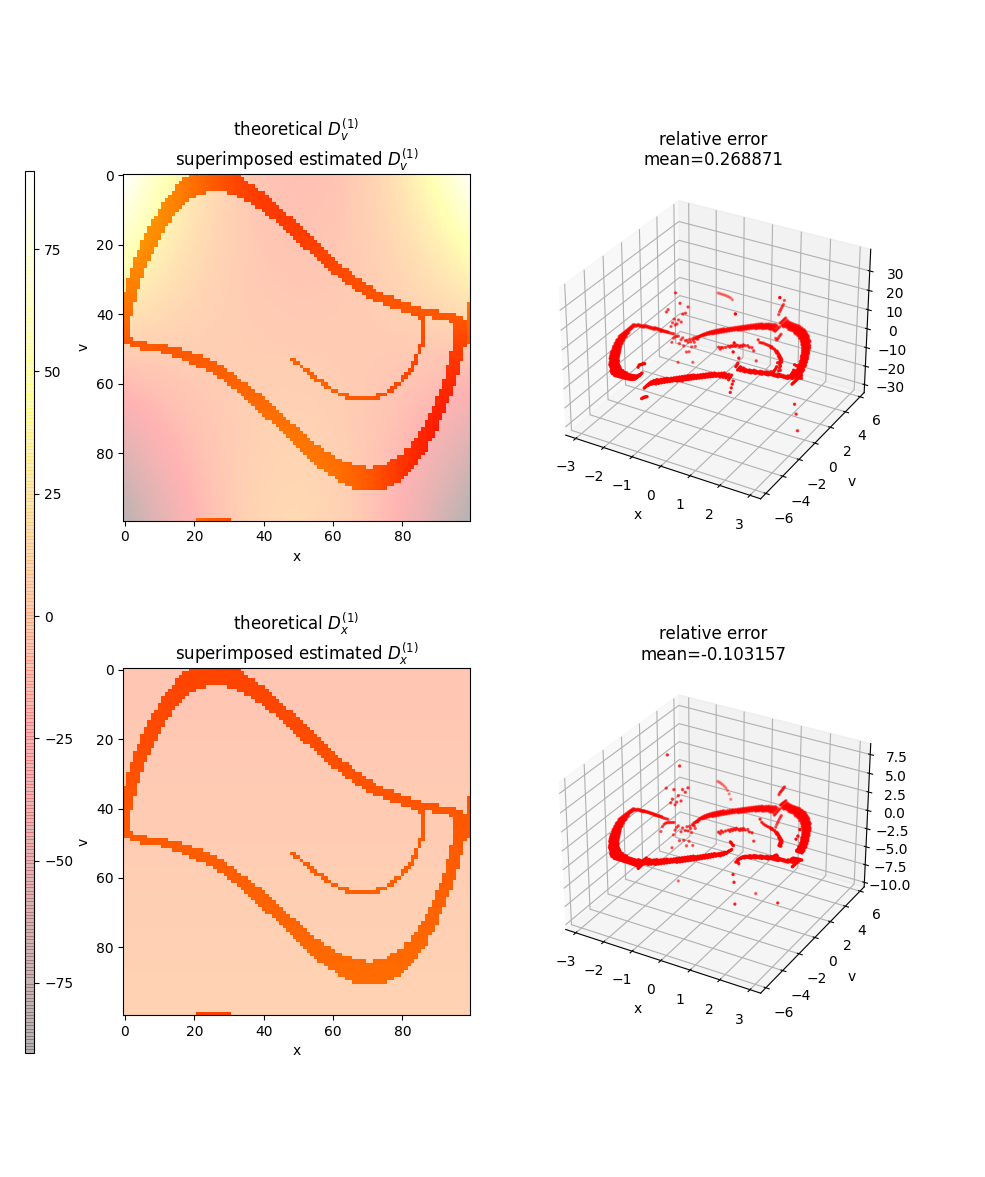

These follow the teoretical values closely in regions visited frequently by the oscillator. In regions (bins) which are not frequently visited by the oscillator the values do not exactly match the teoretical ones. 

There are also some left artifacts at the boundaries. This is due to the not exact mapping of the used transform function.

Also the systems diffusion coefficients shown in Fig. 3 were estimated. Note that $D^{(2)}_{xx} = D^{(2)}_{vv} = 0$, which is why they aren't shown.


Reasonably we can reconstruct a time series with identical dynamics using the estimated coefficients. The deterministic alongside the stochastic dynamics can be reconstructed using [1]:

$$
X_i(t + \Delta t) = X_i(t)+ D_i^{(1)}(\vec{X}(t)) \Delta t + \sqrt{\Delta t} \sum_{j=1}^i g_{ij}(\vec{X}(t)) \Gamma_j(t)
$$

In Fig. 4 a section of the original time series is shown alongside a reconstructed series with the estimated drift coefficient.

![VdP_series_original_reconstructed.png](./misc/outputs/timeseries/second/VdP_series_original_reconstructed.png)

## Solving the Fokker Planck equation

## References
[1] J.Gradisek, S.Riegert, R.Freidrich, I.Grabec, Analysis of time series from stochastic processes (PHYSICAL REVIEW E, VOLUME 62, NUMBER 3, 2000)
\
[2] H. Risken, The Fokker–Planck Equation (Springer-Verlag, Berlin, 1989).